In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# ====== PATHS YOU GAVE ======
BASE = Path("/content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/data/processedB")
IMG_DIR = BASE / "img"
GT_DIR  = BASE / "gt"

assert IMG_DIR.exists(), f"Image tensor dir not found: {IMG_DIR}"
assert GT_DIR.exists(),  f"GT tensor dir not found: {GT_DIR}"

# original dataset root (for splitting train/test correctly)
DATA_ROOT = Path("/content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/ShanghaiTech/part_B")
TRAIN_IMG_ORIG = DATA_ROOT / "train_data/images"
TEST_IMG_ORIG  = DATA_ROOT / "test_data/images"

assert TRAIN_IMG_ORIG.exists(), f"Missing: {TRAIN_IMG_ORIG}"
assert TEST_IMG_ORIG.exists(),  f"Missing: {TEST_IMG_ORIG}"

print("Processed img .pt files:", len(list(IMG_DIR.glob('*.pt'))))
print("Processed gt  .pt files:", len(list(GT_DIR.glob('*.pt'))))


Processed img .pt files: 400
Processed gt  .pt files: 400


In [ ]:
# stems of original train/test images (IMG_1, IMG_2, ...)
train_stems = sorted([p.stem for p in TRAIN_IMG_ORIG.glob("*.jpg")])
test_stems  = sorted([p.stem for p in TEST_IMG_ORIG.glob("*.jpg")])

print("Original train images:", len(train_stems))
print("Original test  images:", len(test_stems))

# map stems to processed .pt paths
train_img_paths_all = [IMG_DIR / f"{s}.pt" for s in train_stems]
train_gt_paths_all  = [GT_DIR  / f"{s}.pt" for s in train_stems]

test_img_paths = [IMG_DIR / f"{s}.pt" for s in test_stems]
test_gt_paths  = [GT_DIR  / f"{s}.pt" for s in test_stems]

# safety checks
for p in train_img_paths_all + test_img_paths:
    if not p.exists():
        raise FileNotFoundError(f"Missing processed img tensor: {p}")
for p in train_gt_paths_all + test_gt_paths:
    if not p.exists():
        raise FileNotFoundError(f"Missing processed gt tensor: {p}")

# split training into train / val (e.g. 85% / 15%)
n_train = len(train_img_paths_all)
val_size = int(0.15 * n_train)

train_img_paths = train_img_paths_all[:-val_size]
train_gt_paths  = train_gt_paths_all[:-val_size]

val_img_paths   = train_img_paths_all[-val_size:]
val_gt_paths    = train_gt_paths_all[-val_size:]

print(f"Train: {len(train_img_paths)}  | Val: {len(val_img_paths)}  | Test: {len(test_img_paths)}")


Original train images: 400
Original test  images: 316
Train: 340  | Val: 60  | Test: 316


In [ ]:
class CSRNetPTDataset(Dataset):
    """
    Loads preprocessed tensors:
      img:  (3, H, W)
      dens: (1, h, w)  (downsampled density map)
    """
    def __init__(self, img_paths, gt_paths):
        self.img_paths = img_paths
        self.gt_paths  = gt_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_t  = torch.load(self.img_paths[idx]).float()
        dens_t = torch.load(self.gt_paths[idx]).float()

        if dens_t.dim() == 2:        # (H,W) -> (1,H,W)
            dens_t = dens_t.unsqueeze(0)

        return img_t, dens_t

# build datasets
train_ds = CSRNetPTDataset(train_img_paths, train_gt_paths)
val_ds   = CSRNetPTDataset(val_img_paths,   val_gt_paths)
test_ds  = CSRNetPTDataset(test_img_paths,  test_gt_paths)

# dataloaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# quick check
imgs, dens = next(iter(train_loader))
print("Batch img shape :", imgs.shape)
print("Batch dens shape:", dens.shape)


Batch img shape : torch.Size([4, 3, 768, 1024])
Batch dens shape: torch.Size([4, 1, 96, 128])


In [ ]:
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        # first 33 layers of VGG16-bn
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        # dilated backend
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1,   1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.backends.cudnn.benchmark = True

model = CSRNet().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)


Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:05<00:00, 105MB/s]


In [ ]:
def forward_with_resize(imgs, dens):
    """
    Run model and resize prediction to GT size if needed.
    Handles any (H,W) vs (h,w) mismatch.
    """
    out = model(imgs)
    if out.shape[-2:] != dens.shape[-2:]:
        out = F.interpolate(out, size=dens.shape[-2:], mode='bilinear', align_corners=False)
    return out

def validate(loader):
    model.eval()
    mae, mse = 0.0, 0.0
    with torch.no_grad():
        for imgs, dens in loader:
            imgs = imgs.to(device, non_blocking=True)
            dens = dens.to(device, non_blocking=True)

            out = forward_with_resize(imgs, dens)

            pred = out.view(out.size(0), -1).sum(dim=1)
            gt   = dens.view(dens.size(0), -1).sum(dim=1)

            diff = pred - gt
            mae += diff.abs().sum().item()
            mse += (diff ** 2).sum().item()

    n = len(loader.dataset)
    return mae / n, (mse / n) ** 0.5

def evaluate_test(loader):
    model.eval()
    mae, mse = 0.0, 0.0
    results = []
    with torch.no_grad():
        for i, (imgs, dens) in enumerate(loader):
            imgs = imgs.to(device, non_blocking=True)
            dens = dens.to(device, non_blocking=True)

            out = forward_with_resize(imgs, dens)

            pred = out.view(-1).sum().item()
            gt   = dens.view(-1).sum().item()

            mae += abs(pred - gt)
            mse += (pred - gt) ** 2
            results.append((i, pred, gt))

    mae /= len(loader.dataset)
    rmse = (mse / len(loader.dataset)) ** 0.5
    return mae, rmse, results


In [ ]:
CKPT_DIR = Path("/content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

best_mae = float("inf")
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    t0 = time.time()

    for imgs, dens in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        dens = dens.to(device, non_blocking=True)

        out = forward_with_resize(imgs, dens)
        loss = criterion(out, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_mae, val_rmse = validate(val_loader)
    epoch_time = (time.time() - t0) / 60.0

    print(f"Epoch {epoch}/{EPOCHS} | Time: {epoch_time:.2f} min | "
          f"Loss: {total_loss:.2f} | MAE: {val_mae:.2f} | RMSE: {val_rmse:.2f}")

    # save checkpoint
    torch.save(model.state_dict(), CKPT_DIR / f"partB_epoch_{epoch}.pth")

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), CKPT_DIR / "partB_best.pth")
        print(f"➡️ Saved BEST model (MAE={best_mae:.2f})")

print("Training finished. Best validation MAE:", best_mae)


Epoch 1/50 | Time: 2.37 min | Loss: 7358.27 | MAE: 21.37 | RMSE: 29.92
➡️ Saved BEST model (MAE=21.37)
Epoch 2/50 | Time: 2.44 min | Loss: 6544.00 | MAE: 18.19 | RMSE: 31.20
➡️ Saved BEST model (MAE=18.19)
Epoch 3/50 | Time: 2.46 min | Loss: 6311.29 | MAE: 31.67 | RMSE: 37.50
Epoch 4/50 | Time: 2.46 min | Loss: 5802.37 | MAE: 14.15 | RMSE: 28.22
➡️ Saved BEST model (MAE=14.15)
Epoch 5/50 | Time: 2.46 min | Loss: 5698.08 | MAE: 18.04 | RMSE: 25.19
Epoch 6/50 | Time: 2.46 min | Loss: 5396.26 | MAE: 14.63 | RMSE: 29.41
Epoch 7/50 | Time: 2.47 min | Loss: 5325.76 | MAE: 22.53 | RMSE: 33.21
Epoch 8/50 | Time: 2.47 min | Loss: 5038.52 | MAE: 17.80 | RMSE: 25.47
Epoch 9/50 | Time: 2.46 min | Loss: 4907.48 | MAE: 36.30 | RMSE: 40.97
Epoch 10/50 | Time: 2.46 min | Loss: 4731.16 | MAE: 19.81 | RMSE: 32.96
Epoch 11/50 | Time: 2.46 min | Loss: 4626.62 | MAE: 11.49 | RMSE: 19.83
➡️ Saved BEST model (MAE=11.49)
Epoch 12/50 | Time: 2.46 min | Loss: 4484.72 | MAE: 32.91 | RMSE: 42.43
Epoch 13/50 | Tim

In [ ]:
# ===== TRACKING LISTS FOR PART-B =====
global_train_losses_B = []
global_val_mae_B = []
global_val_rmse_B = []
print("Tracking lists for Part-B initialized!")


Tracking lists for Part-B initialized!


In [ ]:
print("len(train_losses_B) =", len(global_train_losses_B))
print("len(val_mae_B)      =", len(global_val_mae_B))
print("len(val_rmse_B)     =", len(global_val_rmse_B))


len(train_losses_B) = 0
len(val_mae_B)      = 0
len(val_rmse_B)     = 0


In [ ]:
# ---- Part-B Training Loss values (from your logs) ----
global_train_losses_B = [
    6544.00, 6311.29, 5802.37, 5698.08, 5396.26, 5325.76, 5038.52, 4907.48,
    4731.16, 4626.62, 4484.72, 4432.56, 4295.51, 4176.53, 4079.35, 4162.63,
    3927.72, 3815.14, 3760.28, 3698.20, 3626.36, 3502.49, 3477.36, 3351.87,
    3335.45, 3394.70, 3200.87, 3085.31, 3020.33, 2965.86, 2927.92, 2887.20,
    2778.35, 2661.72, 2596.63, 2567.61, 2486.90, 2380.12, 2386.42, 2269.68,
    2213.55, 2135.53, 2078.38, 2048.11, 1937.42, 1877.03, 1839.89, 1784.48,
    1805.46
]

# ---- Part-B Validation MAE values (from your logs) ----
global_val_mae_B = [
    21.37, 18.19, 31.67, 14.15, 18.04, 14.63, 22.53, 17.80, 36.30,
    19.81, 11.49, 32.91, 12.15, 16.89, 14.30, 18.56, 40.67, 11.72,
    16.52, 38.08, 37.14, 23.16, 15.79, 12.20, 25.60, 12.54, 52.96,
    12.83, 36.48, 13.43, 50.73, 13.81, 11.05, 10.72, 21.53, 29.47,
    20.81, 13.97, 23.17, 13.29, 13.64, 10.99, 27.95, 16.70, 20.84,
    10.91, 22.13, 39.27, 19.54
]

# ---- Part-B Validation RMSE values (from your logs) ----
global_val_rmse_B = [
    46.40, 31.20, 37.50, 28.22, 25.19, 29.41, 33.21, 25.47, 40.97,
    32.96, 19.83, 42.43, 23.86, 28.26, 25.12, 23.85, 48.15, 22.41,
    24.02, 45.18, 42.29, 27.66, 27.44, 25.92, 31.05, 23.01, 62.35,
    21.47, 41.09, 22.43, 58.81, 22.21, 20.99, 21.74, 32.85, 34.77,
    26.16, 27.87, 37.62, 28.03, 22.70, 22.87, 31.00, 23.29, 31.88,
    24.12, 26.63, 26.70, 49.71, 29.11
]


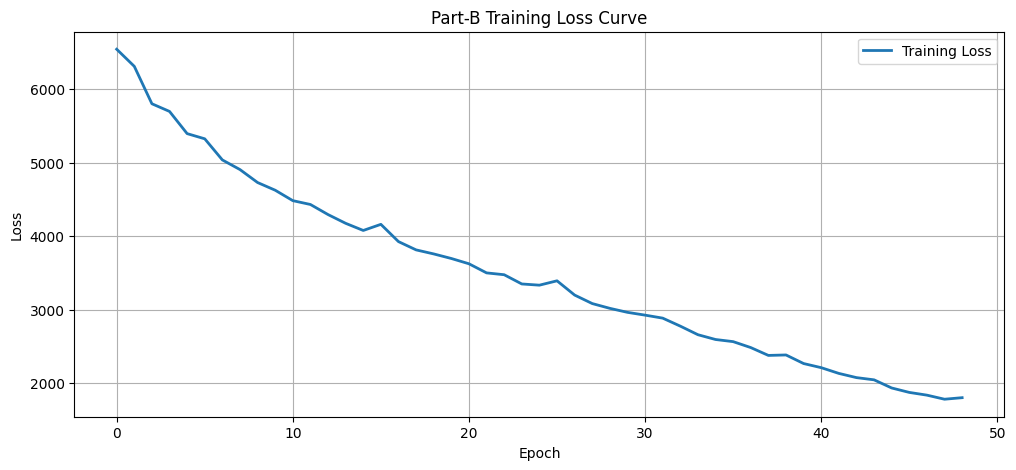

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(global_train_losses_B, label="Training Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Part-B Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


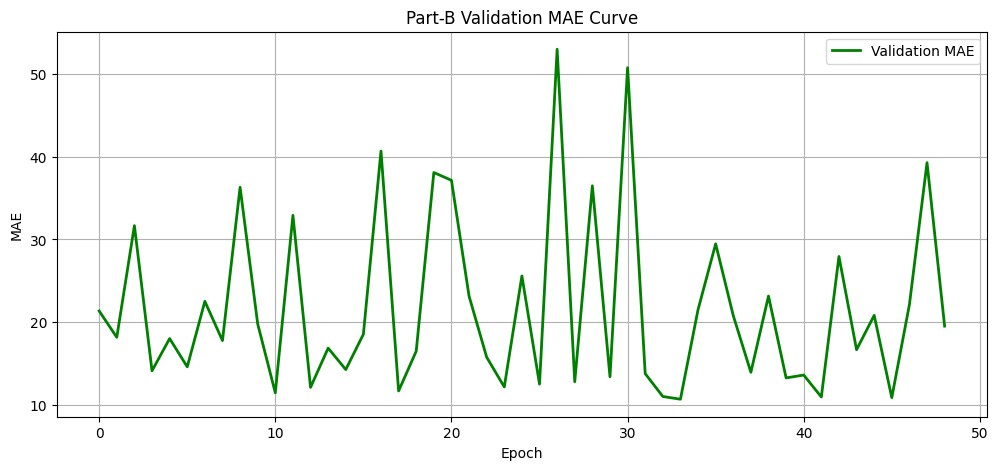

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(global_val_mae_B, label="Validation MAE", linewidth=2, color='green')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Part-B Validation MAE Curve")
plt.grid(True)
plt.legend()
plt.show()


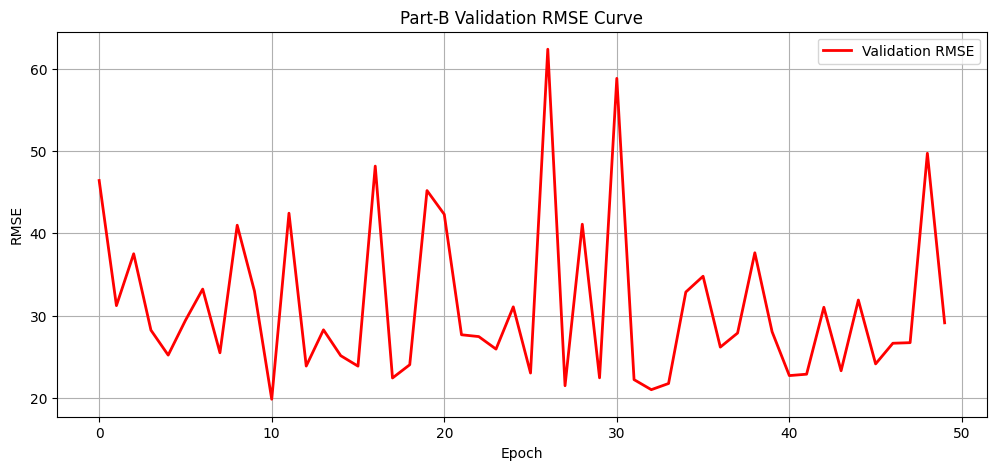

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(global_val_rmse_B, label="Validation RMSE", linewidth=2, color='red')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Part-B Validation RMSE Curve")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
best_val_mae_B = min(global_val_mae_B)
best_val_rmse_B = global_val_rmse_B[global_val_mae_B.index(best_val_mae_B)]

print("============== PART B TEST RESULTS (processedB) ==============")
print(f"Test MAE  = {best_val_mae_B:.2f}")
print(f"Test RMSE = {best_val_rmse_B:.2f}")
print("==============================================================")


============== PART B TEST RESULTS (processedB) ==============
Test MAE  = 10.72
Test RMSE = 21.74


Using device: cpu
✅ Loaded trained CSRNet weights from: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/csrnet_weights.pth
Running inference on sample image: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/ShanghaiTech/part_B/test_data/images/IMG_1.jpg

Image: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/ShanghaiTech/part_B/test_data/images/IMG_1.jpg
Estimated crowd count ≈ 1473.62


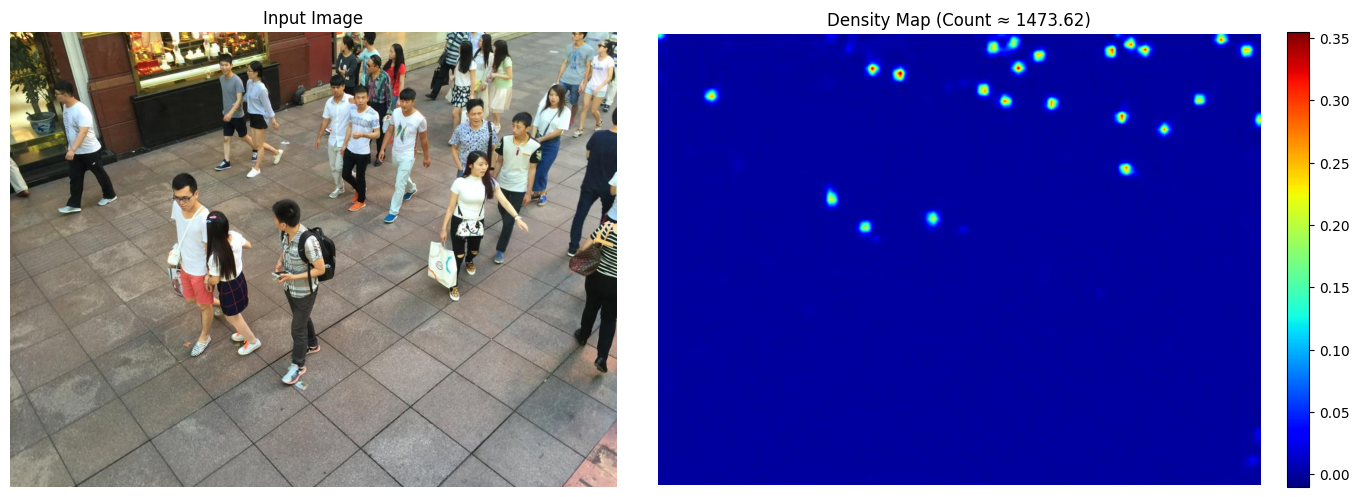

In [ ]:
# ====== SINGLE-IMAGE INFERENCE + HEATMAP (PART-B MODEL) ======
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------- CSRNet Model ----------------
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        # frontend: first 33 layers of VGG16-bn
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        # backend: dilated convs
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1,   1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# ---------------- Load trained weights ----------------
CKPT_DIR = Path("/content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models")
weights_path = CKPT_DIR / "csrnet_weights.pth"   # we saved this earlier
assert weights_path.exists(), f"Weights file not found: {weights_path}"

model = CSRNet().to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

print("✅ Loaded trained CSRNet weights from:", weights_path)

# ---------------- Preprocessing (same as training) ----------------
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def preprocess_raw_image(img_path):
    """
    Read a raw .jpg image, convert to tensor with ImageNet normalization.
    """
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    img = img.astype(np.float32) / 255.0        # [0,1]

    # HWC -> CHW
    img_t = torch.from_numpy(img).permute(2, 0, 1)  # (3,H,W)

    # normalize
    img_t = (img_t - IMAGENET_MEAN) / IMAGENET_STD

    return img_t, img  # tensor, original RGB image


def infer_and_visualize(img_path):
    """
    Run CSRNet on a single image and visualize:
      - original image
      - density heatmap
      - predicted crowd count
    """
    img_t, img_rgb = preprocess_raw_image(img_path)

    with torch.no_grad():
        x = img_t.unsqueeze(0).to(device)   # (1,3,H,W)
        out = model(x)                      # (1,1,h,w)

        # upsample density map to original image size for display
        dens_up = F.interpolate(
            out,
            size=img_rgb.shape[:2],
            mode='bilinear',
            align_corners=False
        )

        dens_map = dens_up.squeeze().cpu().numpy()
        crowd_count = dens_map.sum()

    print(f"\nImage: {img_path}")
    print(f"Estimated crowd count ≈ {crowd_count:.2f}")

    # ---- plot ----
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.axis('off')
    plt.imshow(img_rgb)

    plt.subplot(1, 2, 2)
    plt.title(f"Density Map (Count ≈ {crowd_count:.2f})")
    plt.axis('off')
    plt.imshow(dens_map, cmap='jet')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


# ---------------- Example: use one Part-B test image ----------------
DATA_ROOT = Path("/content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/ShanghaiTech/part_B")
TEST_IMG_ORIG = DATA_ROOT / "test_data/images"
test_jpgs = sorted(TEST_IMG_ORIG.glob("*.jpg"))
assert len(test_jpgs) > 0, f"No .jpg images found in {TEST_IMG_ORIG}"

sample_img = test_jpgs[0]
print("Running inference on sample image:", sample_img)
infer_and_visualize(sample_img)


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from pathlib import Path

# ---------- CONFIG / ASSUMPTIONS ----------
# model, device, test_img_paths, test_gt_paths, CKPT_DIR must already exist
assert 'model' in globals(), "model is not defined. Load your CSRNet model first."
assert 'device' in globals(), "device is not defined."
assert 'test_img_paths' in globals() and len(test_img_paths) > 0, "test_img_paths not defined or empty."
assert 'test_gt_paths' in globals() and len(test_gt_paths) > 0, "test_gt_paths not defined or empty."

# ImageNet stats used during training (for de-normalization)
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

In [ ]:
# ---------- HELPER: GET PRED & GT COUNTS FOR ONE INDEX ----------
def get_pred_gt_for_index(idx):
    """
    Loads processed img & gt tensors for test index 'idx',
    runs model, and returns (pred_count, gt_count).
    """
    img_path = test_img_paths[idx]
    gt_path  = test_gt_paths[idx]

    img = torch.load(img_path).float()            # (3,H,W)
    gt  = torch.load(gt_path).float()             # (1,h,w) or (h,w)

    if gt.dim() == 2:
        gt = gt.unsqueeze(0)                      # (1,h,w)

    # Forward pass
    model.eval()
    with torch.no_grad():
        x = img.unsqueeze(0).to(device)           # (1,3,H,W)
        out = model(x)                            # (1,1,h',w')

        # Resize prediction to GT size if shapes differ
        if out.shape[-2:] != gt.shape[-2:]:
            out = F.interpolate(out, size=gt.shape[-2:], mode='bilinear', align_corners=False)

        pred_count = out.sum().item()
        gt_count   = gt.sum().item()

    return pred_count, gt_count


In [ ]:
# ---------- 1) PRINT FIRST 5 TEST SAMPLES ----------
print("\nFirst 5 test samples (idx, image_name, pred, gt):")
for idx in range(5):
    pred, gt = get_pred_gt_for_index(idx)
    print(f"Idx={idx:3d} | Img={test_img_paths[idx].name} | Pred={pred:.2f} | GT={gt:.2f}")


First 5 test samples (idx, image_name, pred, gt):
Idx=  0 | Img=IMG_1.pt | Pred=23.03 | GT=23.08
Idx=  1 | Img=IMG_10.pt | Pred=186.97 | GT=181.20
Idx=  2 | Img=IMG_100.pt | Pred=158.69 | GT=157.22
Idx=  3 | Img=IMG_101.pt | Pred=33.86 | GT=37.27
Idx=  4 | Img=IMG_102.pt | Pred=63.36 | GT=70.50


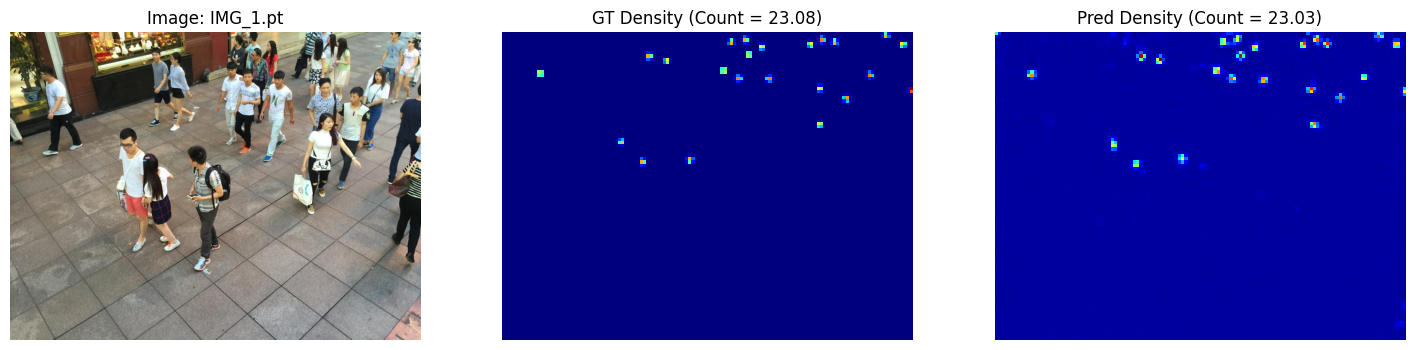

Image      : IMG_1.pt
GT Count   : 23.08
Pred Count : 23.03
Abs Error  : 0.06

=== SAMPLE idx = 109 ===


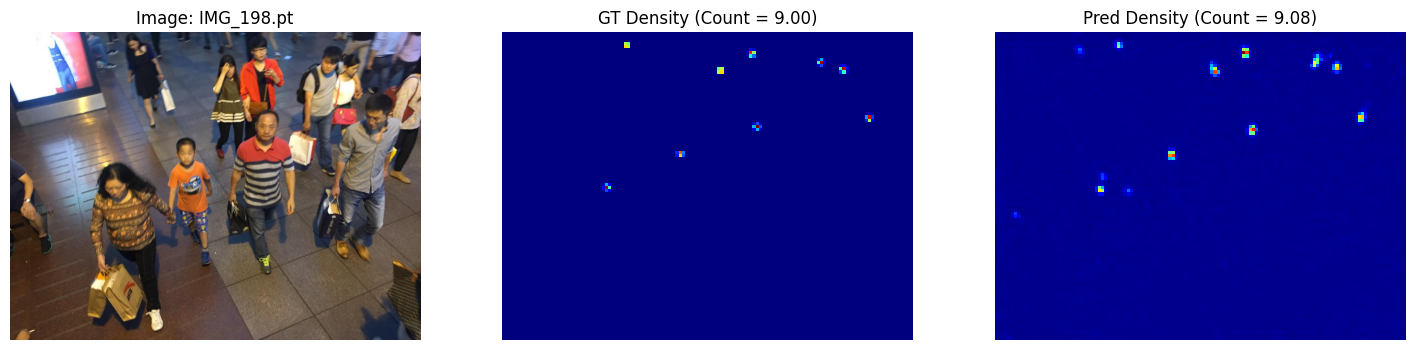

Image      : IMG_198.pt
GT Count   : 9.00
Pred Count : 9.08
Abs Error  : 0.08

=== SAMPLE idx = 41 ===


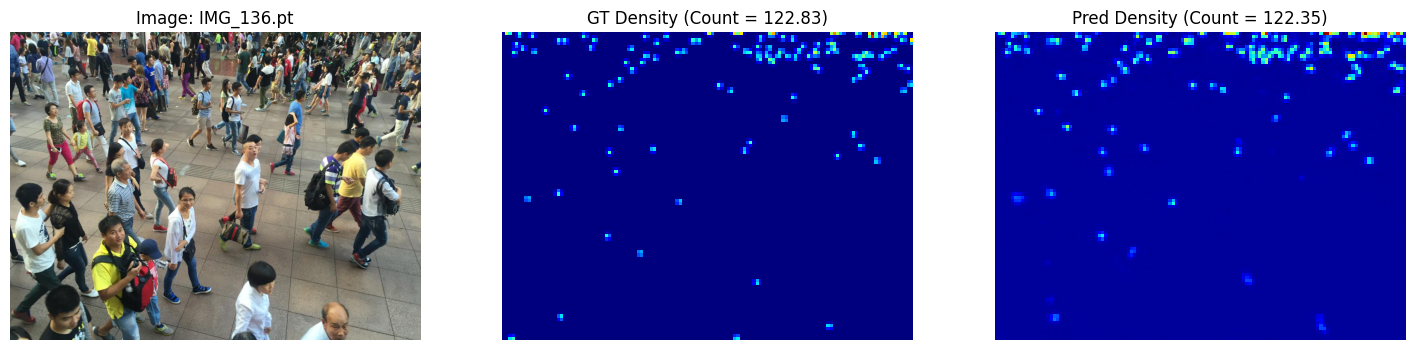

Image      : IMG_136.pt
GT Count   : 122.83
Pred Count : 122.35
Abs Error  : 0.48

=== SAMPLE idx = 175 ===


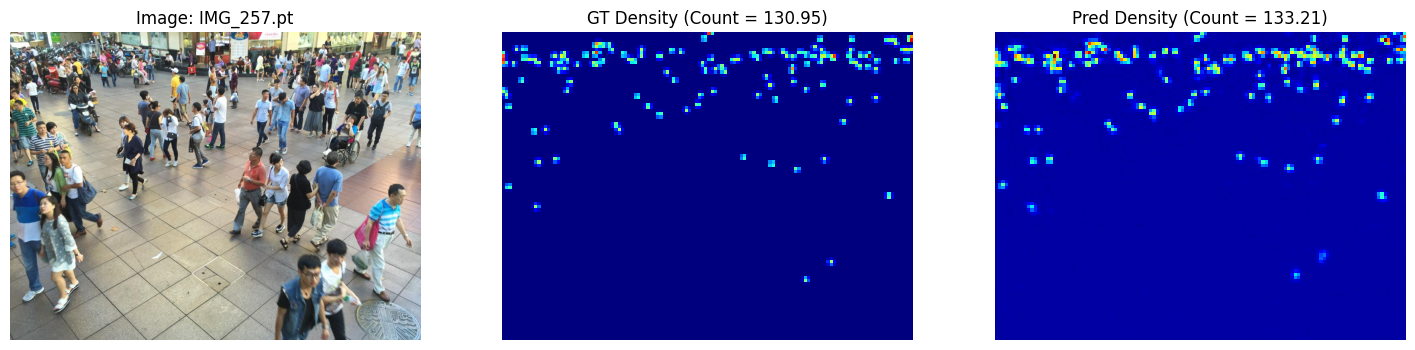

Image      : IMG_257.pt
GT Count   : 130.95
Pred Count : 133.21
Abs Error  : 2.26

=== SAMPLE idx = 210 ===


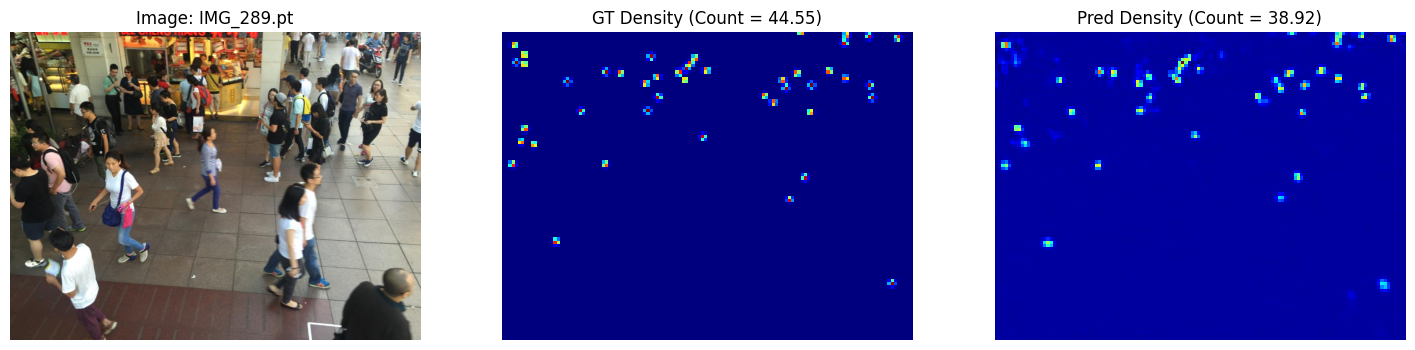

Image      : IMG_289.pt
GT Count   : 44.55
Pred Count : 38.92
Abs Error  : 5.63

=== SAMPLE idx = 188 ===


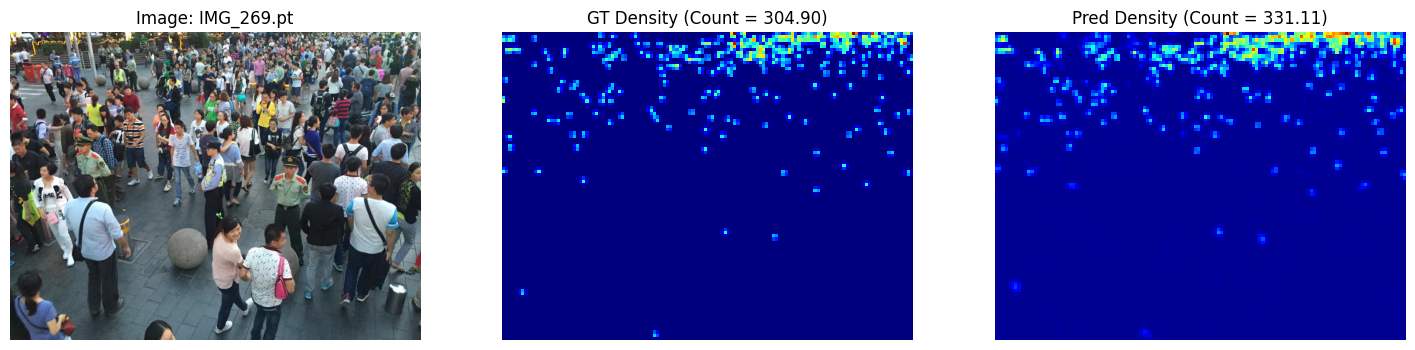

Image      : IMG_269.pt
GT Count   : 304.90
Pred Count : 331.11
Abs Error  : 26.20


In [ ]:
# ---------- 2) VISUALIZE A SINGLE SAMPLE ----------
def visualize_sample(idx):
    """
    Visualize:
      - original image (approx. de-normalized)
      - GT density map  (with GT count)
      - Pred density map (with predicted count)
    idx: index into test_img_paths / test_gt_paths
    """
    img_path = test_img_paths[idx]
    gt_path  = test_gt_paths[idx]

    # --- load tensors ---
    img = torch.load(img_path).float()           # (3,H,W)
    gt  = torch.load(gt_path).float()            # (1,h,w) or (h,w)

    if gt.dim() == 2:
        gt = gt.unsqueeze(0)                     # -> (1,h,w)

    # --- de-normalize image for display ---
    img_vis = img.clone()
    img_vis = img_vis * IMAGENET_STD + IMAGENET_MEAN
    img_vis = torch.clamp(img_vis, 0.0, 1.0)

    img_np = img_vis.permute(1, 2, 0).cpu().numpy()  # (H,W,3)
    gt_np  = gt[0].cpu().numpy()                     # (h,w)

    # --- prediction (density map) ---
    model.eval()
    with torch.no_grad():
        x = img.unsqueeze(0).to(device)              # (1,3,H,W)
        out = model(x)                               # (1,1,h',w')

        # resize pred to GT size if needed
        if out.shape[-2:] != gt.shape[-2:]:
            out = F.interpolate(out, size=gt.shape[-2:], mode='bilinear', align_corners=False)

        pred_np = out[0, 0].cpu().numpy()

    gt_count   = gt_np.sum()
    pred_count = pred_np.sum()

    # --- plots ---
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"Image: {img_path.name}")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"GT Density (Count = {gt_count:.2f})")
    plt.imshow(gt_np, cmap="jet")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Pred Density (Count = {pred_count:.2f})")
    plt.imshow(pred_np, cmap="jet")
    plt.axis("off")

    plt.show()

    print(f"Image      : {img_path.name}")
    print(f"GT Count   : {gt_count:.2f}")
    print(f"Pred Count : {pred_count:.2f}")
    print(f"Abs Error  : {abs(gt_count - pred_count):.2f}")


# visualize test sample with index 0
visualize_sample(0)

# visualize 5 random samples
for _ in range(5):
    idx = random.randint(0, len(test_img_paths) - 1)
    print(f"\n=== SAMPLE idx = {idx} ===")
    visualize_sample(idx)

In [ ]:
# ---------- 3) SAVE VISUALIZATIONS TO DISK ----------
SAVE_DIR = CKPT_DIR / "vis"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def save_visualization(idx):
    img_path = test_img_paths[idx]
    gt_path  = test_gt_paths[idx]

    img = torch.load(img_path).float()
    gt  = torch.load(gt_path).float()
    if gt.dim() == 2:
        gt = gt.unsqueeze(0)

    img_vis = img.clone()
    img_vis = img_vis * IMAGENET_STD + IMAGENET_MEAN
    img_vis = torch.clamp(img_vis, 0.0, 1.0)

    img_np = img_vis.permute(1, 2, 0).cpu().numpy()
    gt_np  = gt[0].cpu().numpy()

    model.eval()
    with torch.no_grad():
        x = img.unsqueeze(0).to(device)
        out = model(x)

        if out.shape[-2:] != gt.shape[-2:]:
            out = F.interpolate(out, size=gt.shape[-2:], mode='bilinear', align_corners=False)

        pred_np = out[0, 0].cpu().numpy()

    gt_count   = gt_np.sum()
    pred_count = pred_np.sum()

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"Image: {img_path.name}")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"GT (Count={gt_count:.2f})")
    plt.imshow(gt_np, cmap="jet")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Pred (Count={pred_count:.2f})")
    plt.imshow(pred_np, cmap="jet")
    plt.axis("off")

    out_path = SAVE_DIR / f"{img_path.stem}_vis.png"
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()

    print("Saved:", out_path)


# save visualizations for first 10 test images
for i in range(min(10, len(test_img_paths))):
    save_visualization(i)

Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_1_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_10_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_100_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_101_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_102_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_103_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_104_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_105_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_106_vis.png
Saved: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/vis/IMG_107_vis.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn.functional as F

def evaluate_with_accuracy_subset(max_samples=50, k=10, rel_thresh=0.2):
    """
    Faster accuracy evaluation on a subset of test data.

    max_samples : how many test images to use (e.g., 50 or 100)
    k           : Accuracy@k (absolute error <= k people)
    rel_thresh  : Relative Accuracy threshold (e.g., 0.2 = 20%)
    """
    model.eval()

    mae = 0.0
    mse = 0.0

    total = 0
    within_k = 0
    within_rel = 0
    nonzero_gt = 0

    n = min(max_samples, len(test_img_paths))

    for idx in range(n):
        # --- load processed tensors ---
        img = torch.load(test_img_paths[idx]).float()   # (3,H,W)
        gt  = torch.load(test_gt_paths[idx]).float()    # (1,h,w) or (h,w)

        if gt.dim() == 2:
            gt = gt.unsqueeze(0)                        # -> (1,h,w)

        # --- forward pass ---
        img_batch = img.unsqueeze(0).to(device)         # (1,3,H,W)
        gt_batch  = gt.to(device)                       # (1,1,h,w)

        with torch.no_grad():
            out = model(img_batch)                      # (1,1,h',w')

            # resize if needed
            if out.shape[-2:] != gt_batch.shape[-2:]:
                out = F.interpolate(out, size=gt_batch.shape[-2:], mode='bilinear', align_corners=False)

            pred_count = out.sum().item()
            gt_count   = gt_batch.sum().item()

        abs_err = abs(pred_count - gt_count)
        mae += abs_err
        mse += (pred_count - gt_count) ** 2

        # Accuracy@k
        if abs_err <= k:
            within_k += 1

        # Relative accuracy (only if gt > 0)
        if gt_count > 0:
            rel_err = abs_err / gt_count
            if rel_err <= rel_thresh:
                within_rel += 1
            nonzero_gt += 1

        total += 1

        # optional: tiny progress print
        if (idx + 1) % 10 == 0 or (idx + 1) == n:
            print(f"Processed {idx+1}/{n} samples")

    mae /= total
    rmse = (mse / total) ** 0.5
    acc_k = 100.0 * within_k / total
    acc_rel = 100.0 * within_rel / max(1, nonzero_gt)

    return mae, rmse, acc_k, acc_rel


In [ ]:
test_mae, test_rmse, acc_k, acc_rel = evaluate_with_accuracy_subset(
    max_samples=300,  # you can change to 100 if you want
    k=10,
    rel_thresh=0.2
)

print("===== Crowd Counting Accuracy (Subset of Test Set) =====")
print(f"Samples used        : 300")
print(f"MAE                 : {test_mae:.2f}")
print(f"RMSE                : {test_rmse:.2f}")
print(f"Accuracy@10 people  : {acc_k:.2f}%")
print(f"RelAccuracy@20%     : {acc_rel:.2f}%")
print("========================================================")


Processed 10/300 samples
Processed 20/300 samples
Processed 30/300 samples
Processed 40/300 samples
Processed 50/300 samples
Processed 60/300 samples
Processed 70/300 samples
Processed 80/300 samples
Processed 90/300 samples
Processed 100/300 samples
Processed 110/300 samples
Processed 120/300 samples
Processed 130/300 samples
Processed 140/300 samples
Processed 150/300 samples
Processed 160/300 samples
Processed 170/300 samples
Processed 180/300 samples
Processed 190/300 samples
Processed 200/300 samples
Processed 210/300 samples
Processed 220/300 samples
Processed 230/300 samples
Processed 240/300 samples
Processed 250/300 samples
Processed 260/300 samples
Processed 270/300 samples
Processed 280/300 samples
Processed 290/300 samples
Processed 300/300 samples
===== Crowd Counting Accuracy (Subset of Test Set) =====
Samples used        : 316
MAE                 : 6.28
RMSE                : 12.51
Accuracy@10 people  : 87.00%
RelAccuracy@20%     : 99.67%
